In [2]:
import os
current_path = os.getcwd()
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import numpy as np
np.seterr(all='raise')
import matplotlib.pyplot as plt
from tqdm import tqdm
import myInput
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
sys.path.append(current_path+'/../calculate_tangent/')

# 3D Polycrystal Initial Condition Generator

This notebook creates a 3D polycrystalline microstructure with domain size 200×200×200 containing three grains with periodic boundary conditions:

- **Grain 0**: A cylinder from the center of one grain boundary with radius of 50 voxels and height of 50, with a half-sphere on one side
- **Grain 1**: A cylinder along grain 0 until the other grain boundary
- **Grain 2**: Occupies the remaining space in the domain

In [86]:
# Define domain dimensions
nx, ny, nz = 200, 200, 200
ng = 3  # Number of grains

# Initialize microstructure array
microstructure = np.zeros((nx, ny, nz, ng), dtype=np.int8)

# Define center of the domain
center_x, center_y = nx // 2, ny // 2

# Parameters for grain 0 (cylinder with half-sphere)
cylinder_radius = 50
cylinder_height = 50
start_z = nz // 4  # Starting z position (1/4 of domain)

# Create a mask for checking points inside cylinder and half-sphere
def is_in_cylinder_with_halfsphere(x, y, z, center_x, center_y, start_z, radius, height):
    # Check if point is within the cylinder radius
    dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Check for cylinder part
    if dist_xy <= radius and start_z <= z < start_z + height:
        return True
    
    # Check for half-sphere part (top of cylinder)
    if z >= start_z + height:
        dist_center = np.sqrt(dist_xy**2 + (z - (start_z + height - np.cos(np.pi/6) * 2 * radius))**2)
        if dist_xy <= radius and dist_center <= 2*radius:
            return True
        
    # Check for half-sphere part (bottom of cylinder)
    if z <= start_z:
        dist_center = np.sqrt(dist_xy**2 + (z - (start_z + np.cos(np.pi/6) * 2 * radius))**2)
        if dist_xy <= radius and dist_center <= 2*radius:
            return True
    
    return False

# Create a mask for checking points inside extending cylinder
def is_in_extending_cylinder(x, y, z, center_x, center_y, start_z, radius, height, grain_base):
    # Check if point is within the cylinder radius
    dist_xy = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # The extending cylinder goes from half-sphere end to the end of domain
    if dist_xy <= radius and (z >= start_z + height or z <= start_z ) and not grain_base[x,y,z]:
        return True
    
    return False

In [87]:
# Generate the microstructure
# Use vectorized operations for better performance
x_coords, y_coords, z_coords = np.meshgrid(
    np.arange(nx), 
    np.arange(ny), 
    np.arange(nz), 
    indexing='ij'
)

# Fill in grain 0 (cylinder with half-sphere)
grain0 = np.zeros((nx, ny, nz), dtype=bool)
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            if is_in_cylinder_with_halfsphere(i, j, k, center_x, center_y, start_z, cylinder_radius, cylinder_height):
                grain0[i, j, k] = True

# Fill in grain 1 (extending cylinder)
grain1 = np.zeros((nx, ny, nz), dtype=bool)
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            if is_in_extending_cylinder(i, j, k, center_x, center_y, start_z, cylinder_radius, cylinder_height, grain0):
                grain1[i, j, k] = True

# Fill in grain 2 (remaining space)
grain2 = ~(grain0 | grain1)

# Assign to microstructure array
microstructure[:, :, :, 0] = grain0
microstructure[:, :, :, 1] = grain1
microstructure[:, :, :, 2] = grain2

# Convert to single array format
# P0 = np.zeros((nx, ny, nz), dtype=np.int8)
P0 = microstructure[:, :, :, 0] * 1 + microstructure[:, :, :, 1] * 2 + microstructure[:, :, :, 2] * 3
# for g in range(ng):
#     P0[microstructure[:, :, :, g]] = g + 1  # Grain IDs starting from 1

In [88]:
# Verify grain volumes
print(f"Grain 0 volume: {np.sum(grain0)} voxels")
print(f"Grain 1 volume: {np.sum(grain1)} voxels")
print(f"Grain 2 volume: {np.sum(grain2)} voxels")
print(f"Total domain size: {nx * ny * nz} voxels")
print(f"Sum of all grains: {np.sum(grain0) + np.sum(grain1) + np.sum(grain2)} voxels")

# Verify that each point belongs to exactly one grain
unique_assignment = (np.sum(microstructure, axis=3) == 1)
print(f"Percentage of points with unique grain assignment: {np.mean(unique_assignment) * 100:.2f}%")

Grain 0 volume: 500125 voxels
Grain 1 volume: 1068875 voxels
Grain 2 volume: 6431000 voxels
Total domain size: 8000000 voxels
Sum of all grains: 8000000 voxels
Percentage of points with unique grain assignment: 100.00%


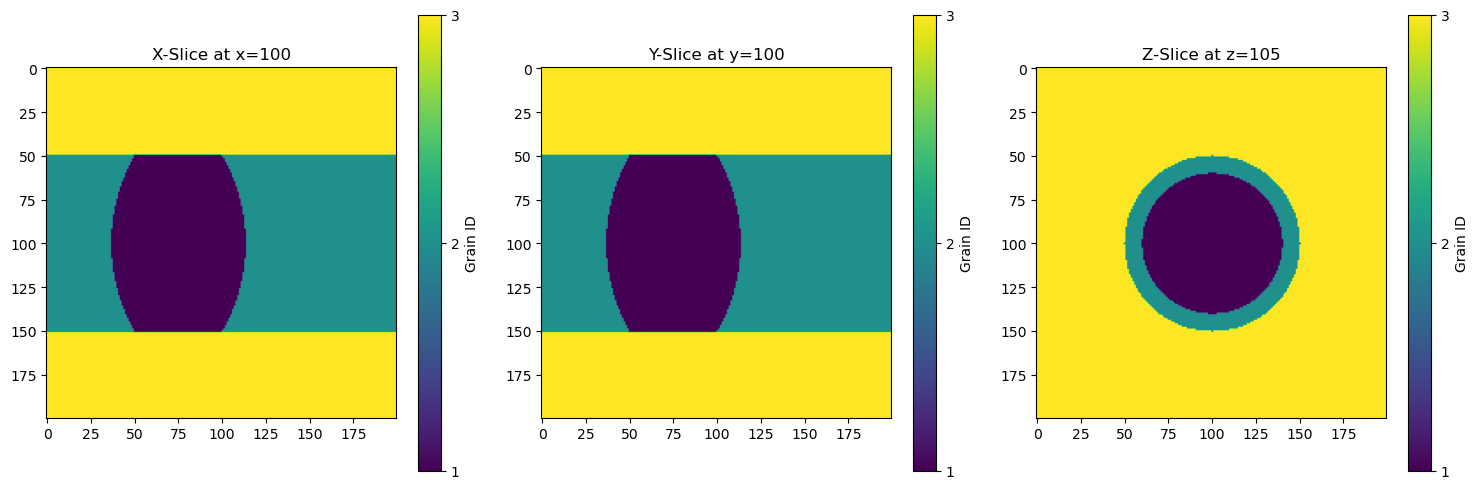

In [89]:
# Visualize mid-slices
plt.figure(figsize=(15, 5))

# X-slice
plt.subplot(131)
plt.imshow(P0[nx//2, :, :], cmap='viridis', vmin=1, vmax=3)
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(ticks=[1, 2, 3], label='Grain ID')

# Y-slice
plt.subplot(132)
plt.imshow(P0[:, ny//2, :], cmap='viridis', vmin=1, vmax=3)
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(ticks=[1, 2, 3], label='Grain ID')

# Z-slice at cylinder half-height
plt.subplot(133)
plt.imshow(P0[:, :, start_z + cylinder_height + 5], cmap='viridis', vmin=1, vmax=3)
plt.title(f'Z-Slice at z={start_z + cylinder_height + 5}')
plt.colorbar(ticks=[1, 2, 3], label='Grain ID')

plt.tight_layout()
plt.show()


## Get curvature result from IO_curvature

In [104]:
import importlib
importlib.reload(post_processing)

# Calculate the curvature dictionary
curvature_matrix = post_processing.IO_curvature(P0)


In [105]:
print("Curvature matrix shape:", len(curvature_matrix))
print("Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)")
for key, value in curvature_matrix.items():
    print(f"GB id: {key}, Value: {value}")

Curvature matrix shape: 3
Curvature dictionary: GB id + Value(inner faces, outer faces, GB area, curvature)
GB id: 5, Value: [ 2.0152000e+04  1.7904000e+04  6.0310000e+04 -2.9274997e-02]
GB id: 4, Value: [ 7.33200000e+03  6.12000000e+03  2.06300000e+04 -4.61416662e-02]
GB id: 2, Value: [1.00600000e+04 1.00760000e+04 2.24576667e+04 5.59558159e-04]


## Get curvature from VECTOR

In [110]:
cores = 8
loop_times = 5
size_x,size_y,size_z = P0.shape
grain_nums = 3
R = np.zeros((size_x,size_y,size_z,4))
smoothing_class = Linear_3D.linear3d_class(size_x,size_y,size_z,grain_nums,cores,loop_times,P0,R,'p',verification_system = True,curvature_sign = True)
smoothing_class.linear3d_main("curvature")
C_ln = smoothing_class.get_C()
curvature_matrix = C_ln[1,:]


my core time is 7.478974
res_back start...
my res time is 0.022597
my core time is 9.087063
res_back start...
my res time is 0.01867
my core time is 10.011742
res_back start...
my res time is 0.008143
my core time is 10.140624
res_back start...
my res time is 0.005783
my core time is 9.427351
res_back start...
my res time is 0.0034
my core time is 8.437211
res_back start...
my res time is 0.00469
my core time is 7.970279
res_back start...
my res time is 0.001947
my core time is 7.549948
res_back start...
my res time is 0.005558
core done!


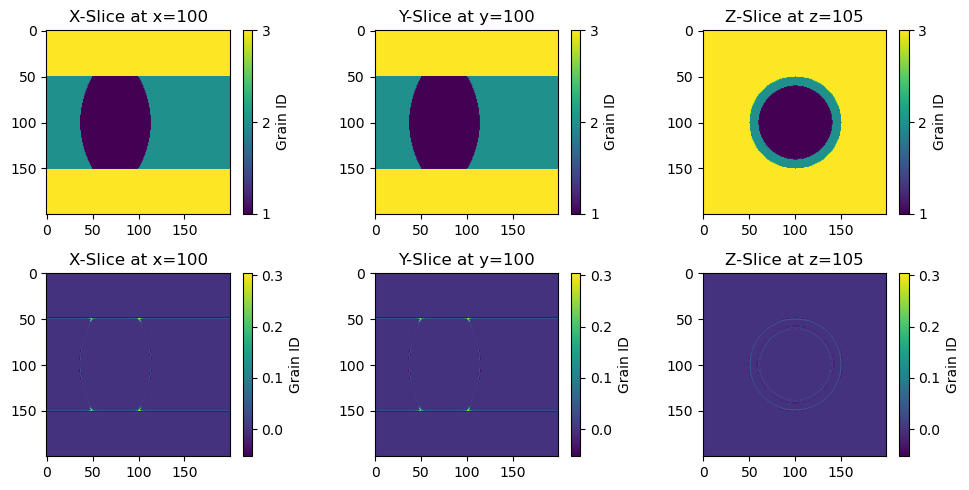

In [95]:
# Visualize mid-slices
plt.figure(figsize=(10, 5))

# X-slice
plt.subplot(231)
plt.imshow(P0[nx//2, :, :], cmap='viridis', vmin=1, vmax=3)
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(ticks=[1, 2, 3], label='Grain ID')

# Y-slice
plt.subplot(232)
plt.imshow(P0[:, ny//2, :], cmap='viridis', vmin=1, vmax=3)
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(ticks=[1, 2, 3], label='Grain ID')

# Z-slice at cylinder half-height
plt.subplot(233)
plt.imshow(P0[:, :, start_z + cylinder_height + 5], cmap='viridis', vmin=1, vmax=3)
plt.title(f'Z-Slice at z={start_z + cylinder_height + 5}')
plt.colorbar(ticks=[1, 2, 3], label='Grain ID')

# curvatrue X-slice 
plt.subplot(234)
plt.imshow(curvature_matrix[nx//2, :, :], cmap='viridis', vmin=np.min(curvature_matrix), vmax=np.max(curvature_matrix))
plt.title(f'X-Slice at x={nx//2}')
plt.colorbar(label='Grain ID')

# curvatrue Y-slice
plt.subplot(235)
plt.imshow(curvature_matrix[:, ny//2, :], cmap='viridis', vmin=np.min(curvature_matrix), vmax=np.max(curvature_matrix))
plt.title(f'Y-Slice at y={ny//2}')
plt.colorbar(label='Grain ID')

# curvatrue Z-slice at cylinder half-height
plt.subplot(236)
plt.imshow(curvature_matrix[:, :, start_z + cylinder_height + 5], cmap='viridis', vmin=np.min(curvature_matrix), vmax=np.max(curvature_matrix))
plt.title(f'Z-Slice at z={start_z + cylinder_height + 5}')
plt.colorbar(label='Grain ID')

plt.tight_layout()
plt.show()


In [118]:
## Dump code for average curvatrue

# Create shifted arrays for all 6 directions at once
neighbors = np.stack([
    np.roll(P0, -1, axis=0),
    np.roll(P0, 1, axis=0),
    np.roll(P0, -1, axis=1),
    np.roll(P0, 1, axis=1),
    np.roll(P0, -1, axis=2),
    np.roll(P0, 1, axis=2)
])

# Find boundary voxels efficiently
boundary_mask = (neighbors != P0[None,...]).any(axis=0)


nx_range_min = 54
nx_range_max = 146
ny_range_min = 54
ny_range_max = 146
curvature_grain1 = 0
num_area_grain1 = 0
curvature_grain2 = 0
num_area_grain2 = 0
for x_i in range(nx):
    for y_i in range(ny):
        for z_i in range(nz):
            current_distance = np.sqrt((x_i - center_x)**2 + (y_i - center_y)**2)
            if current_distance > 45:
                continue
            if P0[x_i,y_i,z_i] == 1 and boundary_mask[x_i,y_i,z_i]:
                curvature_grain1 += curvature_matrix[x_i,y_i,z_i]
                num_area_grain1 += 1
            elif P0[x_i,y_i,z_i] == 2 and boundary_mask[x_i,y_i,z_i]:
                curvature_grain2 += curvature_matrix[x_i,y_i,z_i]
                num_area_grain2 += 1
            elif boundary_mask[x_i,y_i,z_i]:
                print("Error: P0[x_i,y_i,z_i] is not 1 or 2")

average_curvature_grain1 = curvature_grain1 / num_area_grain1 if num_area_grain1 > 0 else 0
average_curvature_grain2 = curvature_grain2 / num_area_grain2 if num_area_grain2 > 0 else 0
print(f"Average curvature for grain 1: {average_curvature_grain1} with GB area {num_area_grain1}")
print(f"Average curvature for grain 2: {average_curvature_grain2} with GB area {num_area_grain2}")
print(f"Average curvature for GB between grain 1 and 2: {(average_curvature_grain1-average_curvature_grain2)/2} with GB area {(num_area_grain1+num_area_grain2)/2}")
print(f"The analytical curvatrue is {1/(2*cylinder_radius)}")

Average curvature for grain 1: 0.010436590496967622 with GB area 12722
Average curvature for grain 2: -0.009537312014794103 with GB area 12722
Average curvature for GB between grain 1 and 2: 0.009986951255880862 with GB area 12722.0
The analytical curvatrue is 0.01


In [ ]:
from collections import defaultdict
from scipy.spatial import cKDTree

TJ_distance_max = 5

# Create shifted arrays for all 6 directions at once
neighbors = np.stack([
    np.roll(P0, -1, axis=0),
    np.roll(P0, 1, axis=0),
    np.roll(P0, -1, axis=1),
    np.roll(P0, 1, axis=1),
    np.roll(P0, -1, axis=2),
    np.roll(P0, 1, axis=2)
])

# Find boundary voxels efficiently
boundary_mask = (neighbors != P0[None,...]).any(axis=0)
boundary_coords = np.argwhere(boundary_mask)

# First pass: Build TJ_information_dict and organize TJ points by pair_id
TJ_infomation_dict = defaultdict(list)
TJ_trees = {}  # KD-trees for each pair_id's TJ points
neighbor_array = neighbors.reshape(6, -1).T

# Process boundary points for triple junctions
for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
    
    if len(unique_neighbors) > 1:  # Triple junction point
        for neighbor in unique_neighbors:
            pair_id = post_processing.get_line(central_site, neighbor)
            TJ_infomation_dict[pair_id].append([i,j,k])
print("Finish TJ information collection")
# Create KD-trees for each pair_id's TJ points
for pair_id, tj_points in TJ_infomation_dict.items():
    tj_points_array = np.array(tj_points)
    TJ_trees[pair_id] = cKDTree(tj_points_array)

# Second pass: Build GB_information_dict
GB_infomation_dict = {}

# Process boundary points for grain boundaries
# Group boundary points by pair_id for batch processing
gb_points_by_pair = defaultdict(list)
gb_central_sites = defaultdict(list)
gb_indices = defaultdict(list)

for idx, (i, j, k) in enumerate(boundary_coords):
    central_site = P0[i,j,k]
    flat_idx = i * size_y * size_z + j * size_z + k
    neighbor_vals = neighbor_array[flat_idx]
    unique_neighbors = np.unique(neighbor_vals[neighbor_vals != central_site])
    
    if len(unique_neighbors) == 1:  # Single boundary point
        neighbor = unique_neighbors[0]
        pair_id = post_processing.get_line(central_site, neighbor)
        pair_id_pair = sorted([central_site, neighbor])
        
        # First update or create GB area count
        if pair_id in GB_infomation_dict:
            GB_infomation_dict[pair_id][5] += 1  # Only update area counter first
        else:
            GB_infomation = np.array([0,0,0,0,0.0,1,pair_id_pair[0],pair_id_pair[1]])  # Initialize with zeros
            GB_infomation_dict[pair_id] = GB_infomation
        
        # Collect points for batch processing
        gb_points_by_pair[pair_id].append([i,j,k])
        gb_central_sites[pair_id].append(central_site)
        gb_indices[pair_id].append([i,j,k])
print("Finish GB information collection")

# Process each pair_id's points in batch
for pair_id, points in gb_points_by_pair.items():
    points_array = np.array(points)
    central_sites = np.array(gb_central_sites[pair_id])
    indices = np.array(gb_indices[pair_id])
    
    # If there are TJ points for this pair_id, check distances
    if pair_id in TJ_trees:
        # Find distances to nearest TJ points for all GB points at once
        distances, _ = TJ_trees[pair_id].query(points_array)
        # Create mask for points far enough from TJ
        far_from_tj_mask = distances >= TJ_distance_max
        
        # Process only points far from TJ
        valid_points = points_array[far_from_tj_mask]
        valid_central_sites = central_sites[far_from_tj_mask]
        valid_indices = indices[far_from_tj_mask]
        
        # Update GB information for valid points
        n_valid = len(valid_points)
        if n_valid == 0: continue
        GB_infomation_dict[pair_id][0] += n_valid
        
        # Calculate curvature signs based on central_site matching pair_id_pair[0]
        curvature_signs = np.where(valid_central_sites == GB_infomation_dict[pair_id][6], 1, -1)
        
        # Update position and curvature information
        pos_ave = np.sum(valid_indices, axis=0) / n_valid
        curv_ave = np.sum(curvature_signs * curvature_matrix[valid_points[:,0], valid_points[:,1], valid_points[:,2]]) / n_valid
        GB_infomation_dict[pair_id][1:4] += pos_ave
        GB_infomation_dict[pair_id][4] += curv_ave
print("Finsh GB information dictionary")

# Post-process GB information
GB_infomation_dict = {k:v for k,v in GB_infomation_dict.items() if v[0] != 0}

print(f"Current GBs len: {len(GB_infomation_dict)}")

Finish TJ information collection
Finish GB information collection
Finsh GB information dictionary
Current GBs len: 3


In [123]:
GB_infomation_dict

{5: array([7.83960000e+04, 1.00000000e+02, 1.00000000e+02, 1.10251799e+02,
        9.77295456e-03, 8.35160000e+04, 2.00000000e+00, 3.00000000e+00]),
 4: array([2.29240000e+04, 1.00000000e+02, 1.00000000e+02, 7.48255104e+01,
        9.69124807e-03, 2.81400000e+04, 1.00000000e+00, 3.00000000e+00]),
 2: array([2.51400000e+04, 1.00000000e+02, 1.00000000e+02, 7.50000000e+01,
        1.00334945e-02, 3.02600000e+04, 1.00000000e+00, 2.00000000e+00])}